# Model Building: Iteration 2 <br/>*Using Pipelines*

### Goals
1. Add numerical variables: Age, Fare, SibSp, and Parch
2. Use pipes to:
   * standardize all variables  
   * impute missing values for Age
   * try new IterativeImputer for Age
3. Compare this model with the first iteration

This notebook demonstrates the use of a Pipeline which is applied to all variables.

IterativeImputer is new to Scikit Learn v0.21 and is currently considered "experimental".

### Common Imports and Notebook Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
%matplotlib inline
sns.set() # enable seaborn style

import titanic_helper_code as tt

In [2]:
# Version Information
import sys
print('python:     ', sys.version)
print('numpy:      ', np.__version__)
print('pandas:     ', pd.__version__)
import matplotlib
print('matplotlib: ', matplotlib.__version__)
print('seaborn:    ', sns.__version__)
print('sklearn:    ', sk.__version__)
!lsb_release -d

python:      3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]
numpy:       1.16.4
pandas:      0.24.2
matplotlib:  3.1.0
seaborn:     0.9.0
sklearn:     0.21.2
Description:	Ubuntu 18.04.2 LTS


In [3]:
from sklearn.linear_model import LogisticRegression, BayesianRidge
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer

### Previous Model Building Iteration
Same as get_Xy_v1 *except*:
* don't drop: Age, Fare, SibSp, and Parch

In [4]:
# Copied from titanic_helper_code.py
def get_Xy_v2(filename='./data/train.csv'):
    """Data Encoding

    Version 2
    * Pclass and Sex encoded as 1/0
    * Age, Fare, SibSp, Parch
    """

    # read data
    all_data = pd.read_csv(filename)
    X = all_data.drop('Survived', axis=1)
    y = all_data['Survived']
    
    # encode data
    X['Sex'] = X['Sex'].replace({'female':1, 'male':0})     
    
    # drop unused columns
    drop_columns = ['PassengerId', 'Name',
                    'Ticket', 'Cabin', 'Embarked']
    X = X.drop(drop_columns, axis=1)
    
    return X, y

In [5]:
X, y = tt.get_Xy_v2()
X.dtypes

Pclass      int64
Sex         int64
Age       float64
SibSp       int64
Parch       int64
Fare      float64
dtype: object

### Transformers
In Scikit Learn, a Transformer object is used to transform the values of a variable.  For example, the Standardize Transformer will compute the mean and standard deviation of a variable's values, and then subtract off the mean and divide by the standard deviation.

Standardize accomplishes this in two steps:
* fit() -- which computes the mean and standard deviation
* transform() -- which uses the already computed mean and standard deviation to transform the data

A Transformer also has a convenience method:
* fit_transform() -- which calls fit() followed by transform()

### Pipes
A Pipeline is essentially a list of data Transformers that can be passed to cross_val_score, GridSearchCV and similar.

For concreteness, Standardize will be used in this example, but all Transformers work similarly.

Example of using Transformer with a train/test split:
```python
ss = StandardScaler()
ss.fit_transform(X_train)
ss.transform(X_test) # not fit_transform!
```

cross_val_score (and similar) create train/test splits internally. It is on these internal train/test splits that ss.fit_transform(X_train) and ss.transform(X_test) must be called.  This is accomplished by placing ss in a Pipeline and passing the pipe to cross_val_score which then invokes the Transformer on the train/test splits.

As per the previous notebook, using ss.fit_transform() *on all the data*, and then calling cross_val_score, will result in data leakage. "Data Leakage" means that the test data was used in the model building process.  Data leakage can result in estimates of model performance that are too high.

### Create a Pipeline and use Cross Value Score
In this example, the Pipeline is applied to all the variables.
1. Standardize
2. Impute: replace missing values with mean value
3. Create a LogisticRegression model
4. Estimate the model's performance on unseen data using cross validation

Notes:  
* Standardize ignores missing values
* SimpleImputer does nothing if there are no missing values

Using low K as per discussion about ranking models with cross validated scores: [RankingModels](https://nbviewer.jupyter.org/github/sdiehl28/tutorial-jupyter-notebooks/blob/master/projects/titanic/Titanic01.ipynb#ModelSelection).

In [6]:
# CV for model comparison, not model evaluation
cv_select = RepeatedStratifiedKFold(n_splits=2, n_repeats=10, random_state=108)

In [7]:
pipe = make_pipeline(StandardScaler(),
                     SimpleImputer(strategy='mean'),
                     LogisticRegression(penalty='l2', C=1.0, 
                                        solver='liblinear'))

scores = cross_val_score(pipe, X, y, cv=cv_select, scoring='accuracy')
tt.print_scores(scores)

20 Scores  min:0.771 max:0.818
CV Mean Score: 0.795 +/- 0.012


### Try Above with Scikit Learn's new IterativeImputer
The [IterativeImputer](https://scikit-learn.org/dev/auto_examples/impute/plot_iterative_imputer_variants_comparison.html) is available as of May 2019, in version Scikit Learn v0.21.

In [8]:
# explictly enable new iterative imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# instantiate a regressor to be used for Age
# so far, the only column being considered that has nulls, is Age
bt = BayesianRidge()

In [9]:
# same as above, but with new imputer
pipe = make_pipeline(StandardScaler(),
                     IterativeImputer(random_state=0, estimator=bt),
                     LogisticRegression(penalty='l2', C=1.0, 
                                        solver='liblinear'))

scores = cross_val_score(pipe, X, y, cv=cv_select, scoring='accuracy')
tt.print_scores(scores)

20 Scores  min:0.784 max:0.832
CV Mean Score: 0.804 +/- 0.014


With the use of SimpleImputer, the score was 0.795 +/- 0.012.  
With the use of IterativeImputer, the score was 0.804 +/- 0.014.

The score with IterativeImputer is just within the confidence interval of the score with SimpleImputer, so IterativeImputer is not definitely helping here, but it may be.  When additional features are added in later iterations, IterativeImputer may help more.

In [10]:
# save scores for comparison with next iteration
np.save("./data/iter02.data", scores)

### Compare Model Performance with Previous Iteration

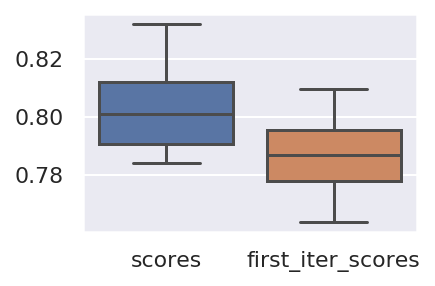

In [11]:
# Read in scores from 1st iteration
first_iter_scores = np.load('./data/iter01.data.npy')

df = pd.DataFrame(data=list(zip(scores, first_iter_scores)),
                  columns=['scores','first_iter_scores'])

plt.figure(figsize=(3,2), dpi=144)
sns.boxplot(data=df);
plt.savefig(fname='2_vs_1.png', dpi=120)

The medians of one box do not overlap the colored part (IQR) of the other box.  This suggests that the difference in performance is not due to chance.

Using a confidence interval of +/- 1 standard deviation is slightly different than using IQR, but it also suggests the difference in performance is not due to chance.

As the initial model considered from EDA is not yet fully developed, it is too soon to reject adding new features that do not provide a performance increase.  After the initial set of features has been added, then the features can be revisited to see if some can be removed, or new ones added.

## Model Summary
Model building steps only.

In [12]:
cv_select = RepeatedStratifiedKFold(n_splits=2, n_repeats=10, 
                                    random_state=108)

X, y = tt.get_Xy_v2()
pipe = make_pipeline(StandardScaler(),
                     IterativeImputer(random_state=0, estimator=bt),
                     LogisticRegression(penalty='l2', C=1.0, 
                                        solver='liblinear'))

scores = cross_val_score(pipe, X, y, cv=cv_select, scoring='accuracy')
tt.print_scores(scores)

20 Scores  min:0.784 max:0.832
CV Mean Score: 0.804 +/- 0.014


In [13]:
# previous model
print(f'Previous Cross Validated Accuracy: {first_iter_scores.mean() :.3f}')

Previous Cross Validated Accuracy: 0.787


## Notebook Summary
In this iteration:
* Age, Fare, SibSp and Parch were added to the model
* All variables were standardized and imputed
  * although only Age had missing values that needed imputation
  * the new IterativeImputer worked well for Age

The model's accuracy improved from 78.7% (in iteration 1) to 80.4%.